c:\Users\angel\.conda\envs\pytorch\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters: {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 50}
Train set accuracy: 91.83%


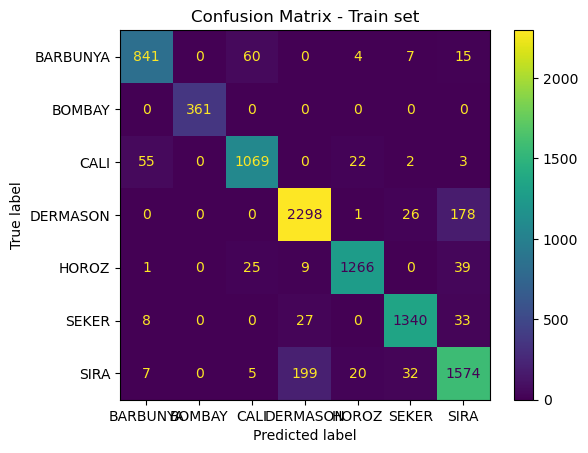

Classification report for train set:
              precision    recall  f1-score   support

    BARBUNYA       0.92      0.91      0.91       927
      BOMBAY       1.00      1.00      1.00       361
        CALI       0.92      0.93      0.93      1151
    DERMASON       0.91      0.92      0.91      2503
       HOROZ       0.96      0.94      0.95      1340
       SEKER       0.95      0.95      0.95      1408
        SIRA       0.85      0.86      0.86      1837

    accuracy                           0.92      9527
   macro avg       0.93      0.93      0.93      9527
weighted avg       0.92      0.92      0.92      9527



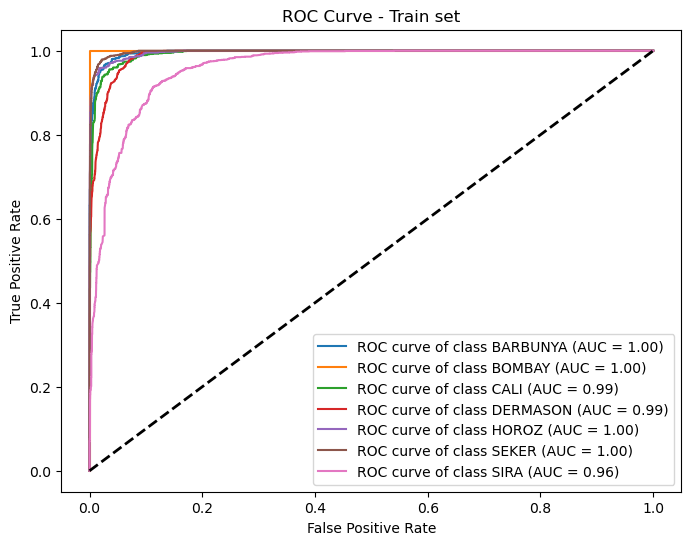

Average AUC (train set): 0.9905
Test set accuracy: 91.36%


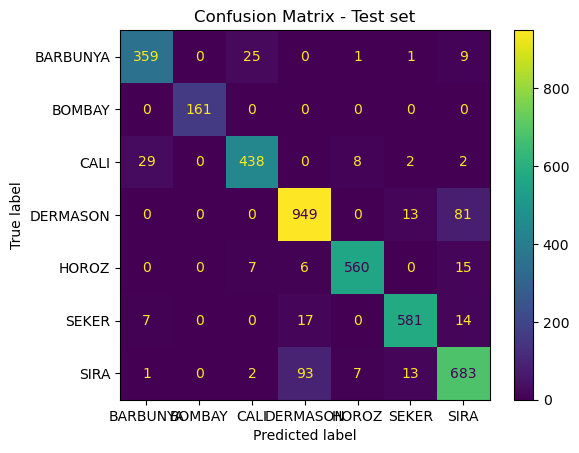

Classification report for test set:
              precision    recall  f1-score   support

    BARBUNYA       0.91      0.91      0.91       395
      BOMBAY       1.00      1.00      1.00       161
        CALI       0.93      0.91      0.92       479
    DERMASON       0.89      0.91      0.90      1043
       HOROZ       0.97      0.95      0.96       588
       SEKER       0.95      0.94      0.95       619
        SIRA       0.85      0.85      0.85       799

    accuracy                           0.91      4084
   macro avg       0.93      0.93      0.93      4084
weighted avg       0.91      0.91      0.91      4084



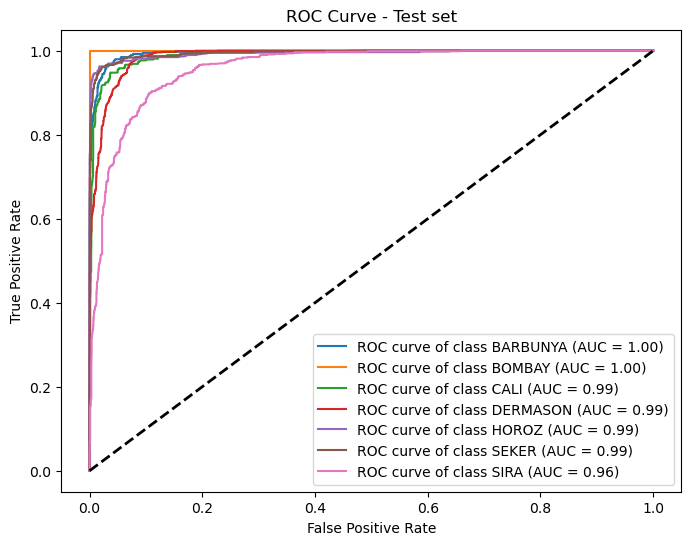

Average AUC (test set): 0.9884
Whole dataset accuracy: 91.69%


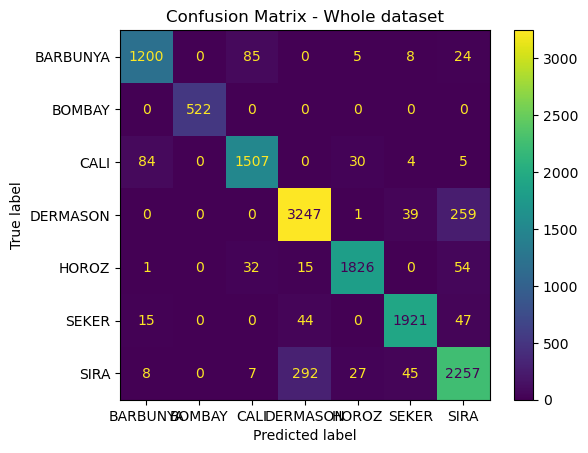

Classification report for whole dataset:
              precision    recall  f1-score   support

    BARBUNYA       0.92      0.91      0.91      1322
      BOMBAY       1.00      1.00      1.00       522
        CALI       0.92      0.92      0.92      1630
    DERMASON       0.90      0.92      0.91      3546
       HOROZ       0.97      0.95      0.96      1928
       SEKER       0.95      0.95      0.95      2027
        SIRA       0.85      0.86      0.85      2636

    accuracy                           0.92     13611
   macro avg       0.93      0.93      0.93     13611
weighted avg       0.92      0.92      0.92     13611



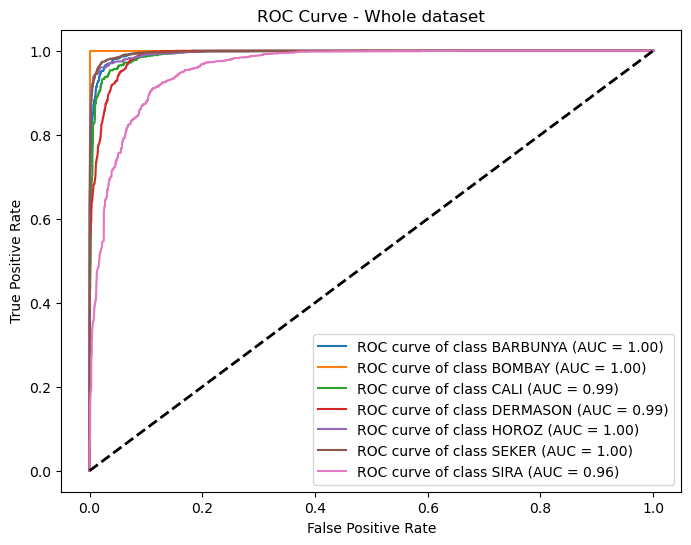

Average AUC (whole dataset): 0.9899


C:\Users\angel\AppData\Local\Temp\ipykernel_15036\2194683350.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

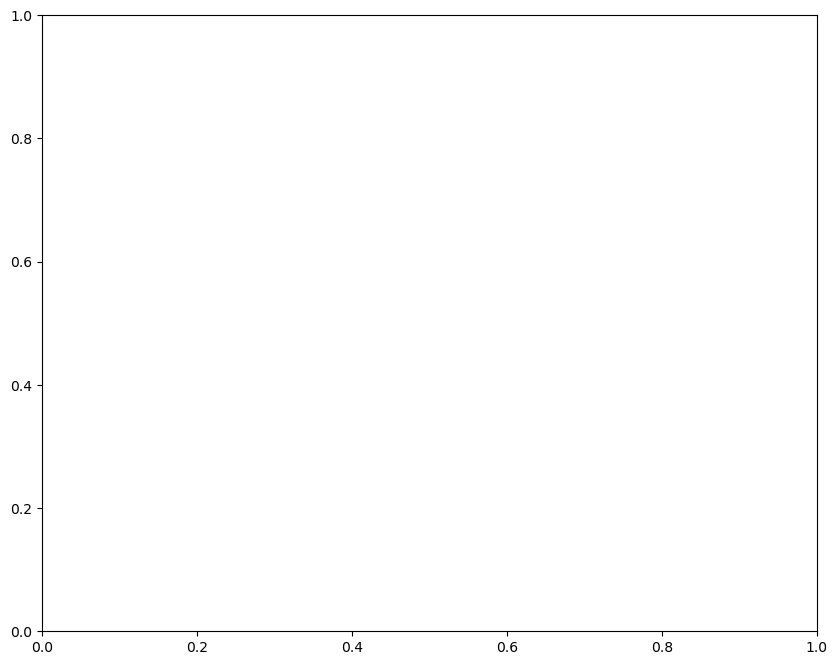

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Set the random seed for reproducibility
np.random.seed(42)

# Load the dataset
data = pd.read_csv("Dry_Bean_Dataset.csv")

# Assume that all columns except "Class" are features
X = data.drop('Class', axis=1)
y = data['Class']
# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Update parameter grid to include base_estimator's max_depth and set algorithm to 'SAMME'
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 1.5],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
    'algorithm': ['SAMME']  # Set algorithm to SAMME
}

# Create the GridSearchCV object with the updated param_grid
grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_ada = grid_search.best_estimator_
# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
#evaluate the model
#define datasets and their names for iteration
# Get class names
classes = np.unique(y)

datasets = [
    ("Train set", X_train, y_train),
    ("Test set", X_test, y_test),
    ("Whole dataset", X, y)
]

for name, X_set, y_set in datasets:
    y_pred = best_ada.predict(X_set)
    accuracy = accuracy_score(y_set, y_pred) * 100
    print(f"{name} accuracy: {accuracy:.2f}%")
    
    # plot confusion matrix
    cm = confusion_matrix(y_set, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    print(f"Classification report for {name.lower()}:")
    print(classification_report(y_set, y_pred, target_names=classes.astype(str)))
    
    # binarize the output for ROC curve (one-vs-rest)
    y_bin = label_binarize(y_set, classes=classes)
    if hasattr(best_ada, "decision_function"):
        y_score = best_ada.decision_function(X_set)
    else:
        y_score = best_ada.predict_proba(X_set)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # calculate and print average AUC
    average_auc = np.mean([roc_auc[i] for i in range(len(classes))])
    print(f'Average AUC ({name.lower()}): {average_auc:.4f}')



C:\Users\angel\AppData\Local\Temp\ipykernel_15036\3203394274.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(xx, yy, Z_numeric, alpha=0.3, levels=len(classes), cmap=plt.cm.get_cmap('tab10', len(classes)))
C:\Users\angel\AppData\Local\Temp\ipykernel_15036\3203394274.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)


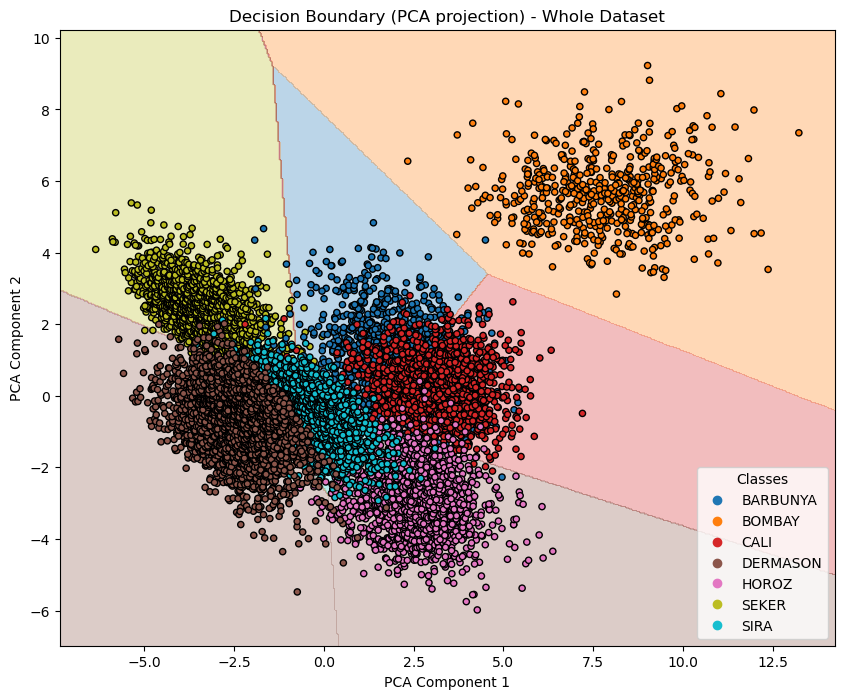

In [4]:
# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit logistic regression on PCA-reduced data for visualization
logreg_vis = LogisticRegression(max_iter=200)
logreg_vis.fit(X_pca, y)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = logreg_vis.predict(np.c_[xx.ravel(), yy.ravel()])

# Map class names to numeric indices
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
Z_numeric = np.vectorize(class_to_index.get)(Z)
Z_numeric = Z_numeric.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z_numeric, alpha=0.3, levels=len(classes), cmap=plt.cm.get_cmap('tab10', len(classes)))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[class_to_index[yy] for yy in y], 
                      cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (PCA projection) - Whole Dataset')

# Add legend using the original class names
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, classes, title="Classes", loc="best")

plt.show()